## ON THE INTERPRETATION OF LEARNING DYNAMICAL SYSTEMS

In [1]:
#---------------------------------------
# Load Libs
#---------------------------------------
import numpy as np
from matplotlib import pylab as plt
from matplotlib import cm
plt.style.use('seaborn-paper')
import matplotlib as mpl
#print(plt.style.available)

import sklearn
import sklearn.manifold
from itertools import cycle
from collections import defaultdict

In [2]:
#---------------------------------------
# Load utility functions
#---------------------------------------
import importlib
import utils 
importlib.reload(utils)
from utils import *

import helper 
importlib.reload(helper)
from helper import *

In [3]:
#---------------------------------------
# Load torch
#---------------------------------------
import torch
device = get_device()

Connected to a GPU


In [4]:
#---------------------------------------
# Set seed
#---------------------------------------
import torch.nn.init as init
np.random.seed(10)
torch.manual_seed(10)

## Example 1: The Simple Harmonic Oscillator 

Select between dampening and no dumpening:

In [5]:
case = 'damped'
case = 'undamped'

if case == 'damped':
    Lambda = np.array(([0,1],[-1,-0.1]))
elif case == 'undamped':
    Lambda = np.array(([0,1],[-1,0]))

Lambda

array([[ 0,  1],
       [-1,  0]])

In [6]:
#---------------------------------------
# Example 1: The Simple Harmonic Oscillator 
# Create Data
#---------------------------------------

t_max = 50
N_time_step = 1000
dt = t_max/N_time_step
anal_ts = np.linspace(0, t_max, N_time_step)

#
u0 = np.array(([0,1]))
data = solution_general_linear(Lambda=Lambda, u0=u0, ts=anal_ts)


data_viz = []
q = .25
for i in range(6):
    
    u_viz = np.array(([0,q]))
    data_viz.append(solution_general_linear(Lambda=Lambda, u0=u_viz, ts=anal_ts))
    q += 0.25


data_viz.append(data)    
    
data += np.random.standard_normal(data.shape) * 0.00

# send to torch
torch_data = data_to_torch(data, device)

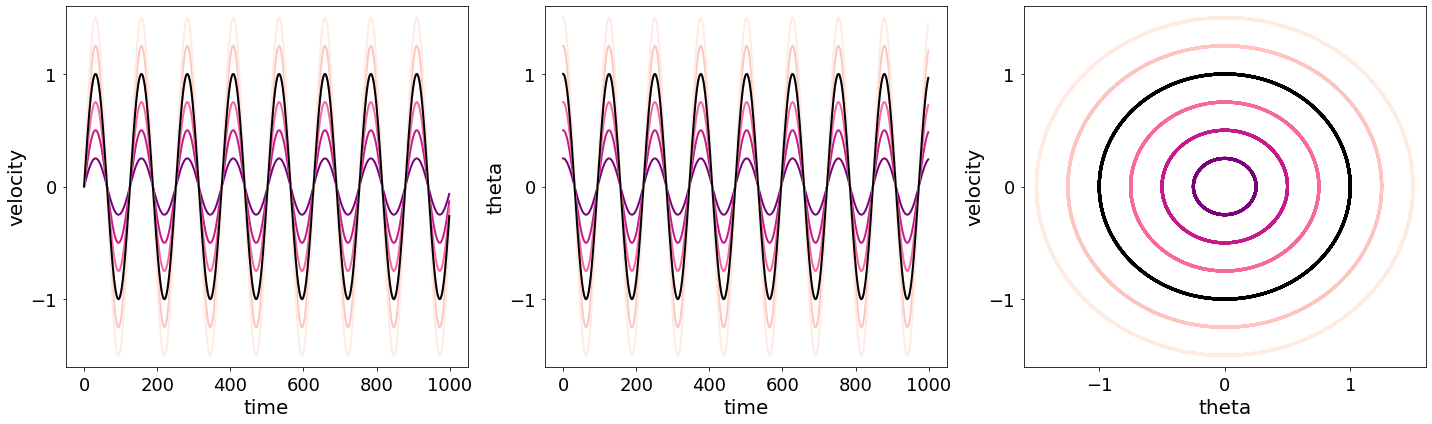

In [7]:
#
# To do: Outsource
#

#---------------------------------------
# Plot Orbit and time series
#---------------------------------------
#fig, (ax1, ax2) = plt.subplots(1, 2)
FIG_SIZE_FULL = (20,6)
def trajectory_plots(trajs):
    
    colors = ['#7a0177', '#c51b8a', '#f768a1', '#fa9fb5', '#fcc5c0', '#feebe2', 'k']
    #colors = ['#7a0177', '#c51b8a', '#f768a1',  'k']
       
    
    plt.figure(figsize=FIG_SIZE_FULL)
    plt.subplot(1,3,1)
    for data, c in zip(trajs, colors):
        plt.plot(data[:,0], lw=2, c=c)
        
    plt.ylabel('velocity', fontsize=20)
    plt.xlabel('time', fontsize=20)
    #plt.legend(loc="best", fontsize=22)
    plt.tick_params(axis='y', labelsize=18)
    plt.tick_params(axis='x', labelsize=18)      
    plt.locator_params(axis='y', nbins=4)
    plt.locator_params(axis='x', nbins=6)
    plt.ylim(-1.6,1.6)

      
    
    plt.subplot(1,3,2)
    for data, c in zip(trajs, colors):
        plt.plot(data[:,1], lw=2, c=c)

    plt.ylabel('theta', fontsize=20)
    plt.xlabel('time', fontsize=20)
    #plt.legend(loc="best", fontsize=22)
    plt.tick_params(axis='y', labelsize=18)
    plt.tick_params(axis='x', labelsize=18)      
    plt.locator_params(axis='y', nbins=4)
    plt.locator_params(axis='x', nbins=6)
    plt.ylim(-1.6,1.6)

    

    plt.subplot(1,3,3)
    for data, c in zip(trajs, colors):
        plt.plot(data[:,0],data[:,1], '-', c=c, lw=3)
        
    plt.ylabel('velocity', fontsize=20)
    plt.xlabel('theta', fontsize=20)
    plt.tick_params(axis='y', labelsize=18)
    plt.tick_params(axis='x', labelsize=18)   
    plt.locator_params(axis='y', nbins=4)
    plt.locator_params(axis='x', nbins=4) 
    plt.xlim(-1.6,1.6)
    plt.ylim(-1.6,1.6)
    
    plt.tight_layout()
    
#trajectory_plots([data])
trajectory_plots(data_viz)

plt.savefig(case + '_ho_viz' + '.eps')


## Learn Omega using SGD

In [8]:
omega, losses, omega_trace  = learn_omega(torch_data, batch_size=50, n_future=1, device=device)

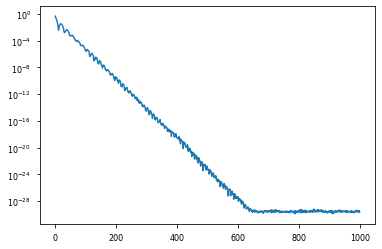

In [9]:
plt.semilogy(losses)

In [10]:
omega_true = true_omega_linear(Lambda, dt=dt)
omega_learned = omega.weight.data.cpu().numpy()

print('True Omega: \n', omega_true)
print('Lerned Omega: \n', omega_learned)

True Omega: 
 [[ 0.99875026  0.04997917]
 [-0.04997917  0.99875026]]
Lerned Omega: 
 [[ 0.99874776  0.05002916]
 [-0.05002916  0.99874776]]


Compute approximation error between learned and true omega:

In [11]:
print(np.linalg.norm(omega_true - omega_learned)) #/ np.linalg.norm(omega_true))

7.078145956843443e-05


Given the learned omega, approximate lambda:

In [12]:
eigs, V = np.linalg.eig(omega.weight.data.cpu().numpy())
lamb_approx = (V.dot(np.diag(np.log(eigs))).dot(np.linalg.inv(V)) * 1/dt).real
print(lamb_approx)

[[-3.62745732e-15  1.00100100e+00]
 [-1.00100100e+00 -3.62745732e-15]]


## Compute DMD

In [13]:
dmd_omega = data[1::,:].T.dot(np.linalg.pinv(data[0:-1,:].T))
print(dmd_omega )

[[ 0.99874776  0.05002916]
 [-0.05002916  0.99874776]]


Compute approximation error between DMD and true omega:

In [14]:
print(np.linalg.norm(omega_true - dmd_omega)) #/ np.linalg.norm(omega_true))

7.07814595708425e-05


## Simulation

In [15]:
omegas = []
omega_traces = []
for i in range(30):
    omega_temp, loss, omega_trace_temp = learn_omega(torch_data, batch_size=50, n_future=1, device=device)
    omegas.append( omega_temp.weight.data.cpu().numpy() )
    omega_traces.append( omega_trace_temp )

In [16]:
# forward euler

error_dmd = []
error_fw = []
error_bw = []
error_tr = []
error_rk4 = []
error_true = []

for omega_est in omegas:
    
    error_dmd.append(np.linalg.norm(dmd_omega - omega_est) / np.linalg.norm(dmd_omega))    
    
    omega_best = operator_factory(Lambda, dt, method='euler')
    error_fw.append(np.linalg.norm(omega_best - omega_est) / np.linalg.norm(omega_best))
    
    omega_best = operator_factory(Lambda, dt, method='bweuler')
    error_bw.append(np.linalg.norm(omega_best - omega_est) / np.linalg.norm(omega_best))

    omega_best = operator_factory(Lambda, dt, method='implicit_trap')
    error_tr.append(np.linalg.norm(omega_best - omega_est) / np.linalg.norm(omega_best))

    omega_best = operator_factory(Lambda, dt, method='rk4')
    error_rk4.append(np.linalg.norm(omega_best - omega_est) / np.linalg.norm(omega_best))

    omega_best = true_omega_linear(Lambda, dt=dt)
    error_true.append(np.linalg.norm(omega_best - omega_est) / np.linalg.norm(omega_best))
        
        
# Importing the statistics module 
from statistics import mean, stdev     

print('dynamic mode decomposition:   ', f"{mean(error_dmd) :1.2e} & {stdev(error_dmd):1.0e}")
print('forward euler:   ', f"{mean(error_fw) :1.2e} & {stdev(error_fw):1.0e}")
print('backward euler:   ', f"{mean(error_bw) :1.2e} & {stdev(error_bw):1.0e}")
print('implicit trap:   ', f"{mean(error_tr) :1.2e} & {stdev(error_tr):1.0e}")
print('rk4:           ', f"{mean(error_rk4) :1.2e} & {stdev(error_rk4):1.0e}")
print('True soltion:   ', f"{mean(error_true) :1.2e} & {stdev(error_true):1.0e}")



dynamic mode decomposition:    8.09e-16 & 5e-16
forward euler:    1.25e-03 & 3e-16
backward euler:    1.25e-03 & 3e-16
implicit trap:    6.05e-05 & 6e-16
rk4:            5.01e-05 & 6e-16
True soltion:    5.01e-05 & 6e-16


In [17]:
#omegas_exp = np.array([ np.array(OM) for oms in [experiments.values()] for OM in omega_traces ]).reshape((-1,4))
flattened_experiment_omegas = np.array([ OM for OM in omegas]).reshape((-1,4))

flattened_traces_omegas = np.array([
    OM for OMS in omega_traces for OM in OMS
]).reshape((-1,4))


list_of_traces_omegas = [
    np.array(OMS).reshape((-1,4)) for OMS in omega_traces ]



In [18]:
path_of_omega_alpha = np.array([one_step_factory(Lambda,dt,alpha) for alpha in np.linspace(0,1,100) ]).reshape((-1,4))

In [19]:
known_omegas = {'True solution':true_omega_linear(Lambda,dt)}
known_omegas.update({
    method:operator_factory(Lambda,dt,method) 
                for method in ['euler', 'bweuler', 'implicit_trap', 'rk4'] })

In [20]:
all_omegas = np.concatenate([
    flattened_traces_omegas,
    path_of_omega_alpha,
    ] + [OM.reshape((-1,4)) for OM in known_omegas.values() ]
    )

In [21]:
#
# To do: Outsource
#


def plot_embedding(TRANSFER, experimental_omegas, path_omega, known_omegas, traces, dmd_omega, mean, sd):
    """Embed and plot the operators, given a callback to the embedding object."""
    
    X_trans_alpha = TRANSFER((path_omega - mean) / sd)
    
    X_trans_exps = TRANSFER((experimental_omegas - mean) / sd)
    
    X_trans_known = { n:TRANSFER((omega.reshape(-1,4) - mean) / sd)  for n, omega in known_omegas.items()}
    
    X_dmd = TRANSFER((dmd_omega - mean) / sd)
    
    
    all_points = cycle('soo****')
    markerdict = defaultdict(lambda : next(all_points))
    
    plt.figure(figsize=(11,7))
    
    # That path of the family
    plt.plot(X_trans_alpha[:,0], X_trans_alpha[:,1],'-', lw=3, color='k')
    #plt.yscale('log') 
    #plt.xscale('log')      
    
    # Known operators
    for n,X in X_trans_known.items():
        plt.plot(X[:,0], X[:,1], markerdict[n], label=n, markersize=20)
    #plt.yscale('log') 
    #plt.xscale('log')  
    #gap = 0.1
    
    # Known operators
    plt.plot(X_dmd[:,0], X_dmd[:,1], 'D',label='DMD', markersize=15, c='#1b9e77')
    #plt.yscale('log') 
    #plt.xscale('log')  

    #gap = 0.1
    
    # Experiments
    plt.plot(X_trans_exps[:,0], X_trans_exps[:,1], 'P',label='experiments', markersize=13, c='#e41a1c')
    #plt.yscale('log') 
    #plt.xscale('log')  
    
    #plotting options
    plt.xlabel("first principal component", fontsize=26)
    plt.ylabel("second principal component", fontsize=26)
    plt.set_cmap('Set3')
    plt.tick_params(axis='x', labelsize=24)
    plt.tick_params(axis='y', labelsize=24)


    L = plt.legend(fontsize=26)
    
    L.get_texts()[0].set_text('True solution')
    L.get_texts()[1].set_text('Forward Euler')
    L.get_texts()[2].set_text('Backward Euler')

    L.get_texts()[3].set_text('Implicit Trap. Rule')
    L.get_texts()[4].set_text('Runge-Kutta (RK4)')
    L.get_texts()[5].set_text('DMD')

    L.get_texts()[6].set_text('Experiments')
    
    plt.ylim(-0.001,0.004)
    plt.xlim(-0.0021,0.0021)
    
    plt.locator_params(axis='y', nbins=5)
    plt.locator_params(axis='x', nbins=5)
   
    
    plt.tight_layout()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[9.99830314e-01 1.69686180e-04 2.82579177e-27 5.73412616e-30]


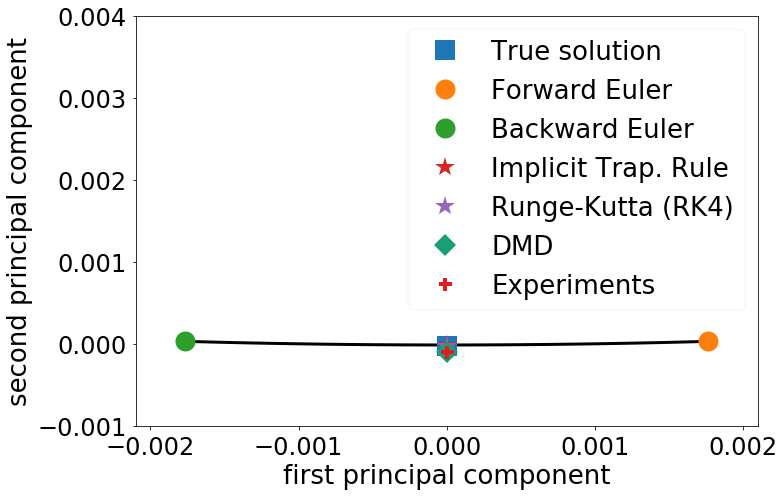

In [22]:
#all_omegas_standardized = sklearn.preprocessing.scale(path_of_omega_alpha, axis=0, with_mean=True, with_std=False, copy=True)

omegas_standardized = path_of_omega_alpha.copy()
all_mean = omegas_standardized.mean(axis=0)
all_sd = omegas_standardized.var(axis=0)**0.5
all_sd = 1
omegas_standardized -=  all_mean
omegas_standardized /= all_sd



pca = sklearn.decomposition.PCA(n_components=4, svd_solver='full', whiten=False)
pca.fit(omegas_standardized)
print(pca.explained_variance_ratio_)

plot_embedding(lambda X : pca.transform(X) / 1,
              flattened_experiment_omegas,
              path_of_omega_alpha,
              known_omegas,
              list_of_traces_omegas,
              dmd_omega.reshape(-1,4),
                all_mean, all_sd)


plt.savefig(case + '_ho_pca' + '.eps')


## Learning the continuous companion matrix

In [23]:
def learn_lambda(data, batch_size=25, n_future=1, verbose=False,
    methods=('FW','BW','TR'), device=None, dt=1, Lambda=None):
    """Perform the one-step learning for a linear matrix."""
    if device is None:
        device = get_device()

    I = torch.eye(2, dtype=torch.double, device=device)
    fwstep = lambda model, y : y + dt*model(y)
    bwstep = lambda model, y : torch.einsum("ij,aj->ai",torch.inverse(I - dt*model.weight),y)
    trstep = lambda model, y : torch.einsum("ij,aj->ai",torch.inverse(I-0.5*dt*model.weight), ( y + 0.5*dt*model(y) ))

    model = torch.nn.Linear(2,2,bias=False).double().to(device)
    optim = torch.optim.Adam(model.parameters(),lr=5.0e-2, weight_decay=0.0)
    loss = torch.nn.MSELoss()
    losses=[]
    losses_lambda = []
    #do_a_path_and_plot(model)

    N_iter = 1000
    N_print = N_iter+1 #//10
    nsamp = data.shape[0] # The harmonic oscillator is periodic so a test set is meaningless
    for opt_iter in range(N_iter):
        idcs = torch.LongTensor(np.random.choice(nsamp-n_future, size=batch_size)).to(device)
        yy = [ torch.index_select(data,0,idcs+i) for i in range(n_future+1) ]
        y_pred_fw = fwstep(model, yy[0])
        y_pred_bw = bwstep(model, yy[0])
        y_pred_tr = trstep(model, yy[0])

        if methods == ('FW','BW','TR'):
            L = loss(yy[1], y_pred_fw) + loss(yy[1], y_pred_bw) + loss(yy[1], y_pred_tr)
            LL = np.linalg.norm(model.weight.data.cpu().numpy()-Lambda) / np.linalg.norm(Lambda)
        elif methods == ('FW','BW'):
            L = loss(yy[1], y_pred_fw) + loss(yy[1], y_pred_bw)
            LL = np.linalg.norm(model.weight.data.cpu().numpy()-Lambda) / np.linalg.norm(Lambda)

        elif methods == ('FW',):
            L = loss(yy[1], y_pred_fw)
            LL = np.linalg.norm(model.weight.data.cpu().numpy()-Lambda) / np.linalg.norm(Lambda)
            
        elif methods == ('BW','TR'):
            L = loss(yy[1], y_pred_bw) + loss(yy[1], y_pred_tr)
            LL = np.linalg.norm(model.weight.data.cpu().numpy()-Lambda) / np.linalg.norm(Lambda)
            
        elif methods == ('BW',):
            L = loss(yy[1], y_pred_bw)
            LL = np.linalg.norm(model.weight.data.cpu().numpy()-Lambda) / np.linalg.norm(Lambda)
            
        else:
            L = loss(yy[1], y_pred_tr)
            LL = np.linalg.norm(model.weight.data.cpu().numpy()-Lambda) / np.linalg.norm(Lambda)
            

        optim.zero_grad()
        L.backward()
        optim.step()
        losses.append(L)
        losses_lambda.append(LL)

        if verbose and opt_iter%N_print==N_print-1:
            print(opt_iter,L.item())
            print(list(model.parameters()))
            #do_a_path_and_plot(model, trstep, ylim=None,nsteps=1000) # This is wrong now

        exp_lr_scheduler(optim, opt_iter, lr_decay_rate=0.3, decayEpoch=[200,500,800])



    if verbose:
        print("Converged with L1: ",losses[-1])

    nump_mat = model.weight.data.cpu().numpy()
    op_tr = np.linalg.inv(np.eye(2) - 0.5*dt*nump_mat).dot( np.eye(2) + 0.5*dt*nump_mat )
    op_fw = np.eye(2) + dt*nump_mat
    op_bw = np.linalg.inv(np.eye(2) - dt*nump_mat)
    return model, np.array([l.cpu().detach().numpy() for l in losses]), nump_mat, op_tr, op_fw, op_bw, losses_lambda

In [24]:
all_method_combos = [
    ('FW','BW','TR'),
    #('FW','BW'),
    ('FW',),
    ('BW',),
    ('TR',)
]
results = {}
for methods in all_method_combos:
    results[methods] = learn_lambda(torch_data, batch_size=25, verbose=True, device=device, methods=methods, dt=dt, Lambda=Lambda)

Converged with L1:  tensor(1.5665e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
Converged with L1:  tensor(2.0182e-30, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Converged with L1:  tensor(1.7560e-30, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Converged with L1:  tensor(2.2027e-30, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


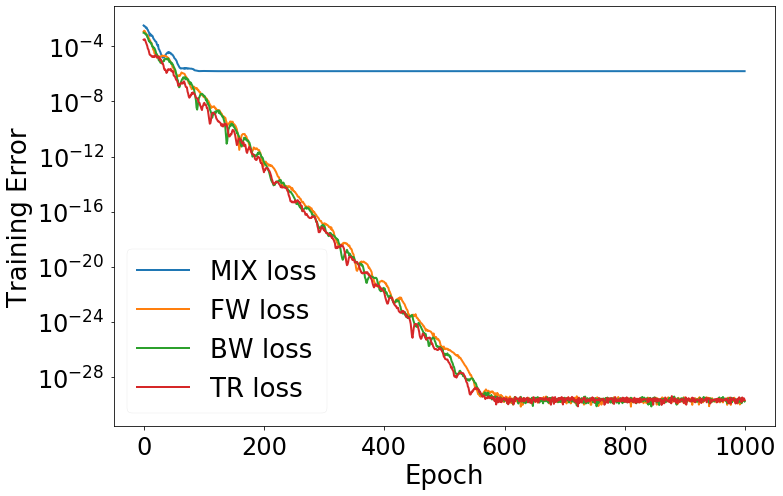

In [25]:
#plt.rcParams.update({'font.size':18})
plt.figure(figsize=(11,7))
for k,(model,loss,mat,tr,fw,bw , loss_lamb) in results.items():
    plt.semilogy(loss,label=k, lw=2)
plt.ylabel('Training Error', fontsize=26)
plt.xlabel('Epoch', fontsize=26)

plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
 
#plt.locator_params(axis='y', nbins=5)
#plt.locator_params(axis='x', nbins=5)
L = plt.legend(fontsize=26)
    
L.get_texts()[0].set_text('MIX loss')
L.get_texts()[1].set_text('FW loss')
L.get_texts()[2].set_text('BW loss')
L.get_texts()[3].set_text('TR loss')

plt.tight_layout()

plt.savefig(case + '_ho_loss_lambda' + '.eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


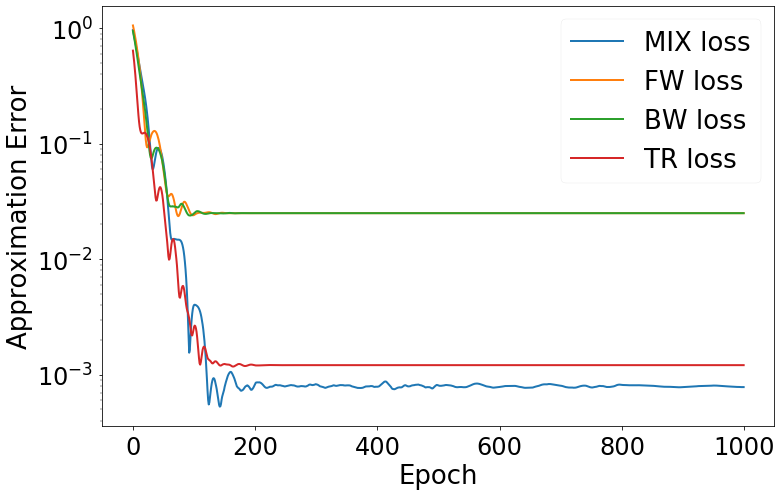

In [26]:
#plt.rcParams.update({'font.size':18})
plt.figure(figsize=(11,7))
for k,(model,loss,mat,tr,fw,bw , loss_lamb) in results.items():
    plt.semilogy(loss_lamb,label=k, lw=2)
plt.ylabel('Approximation Error', fontsize=26)
plt.xlabel('Epoch', fontsize=26)

plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
 
#plt.locator_params(axis='y', nbins=5)
#plt.locator_params(axis='x', nbins=5)
L = plt.legend(fontsize=26)
    
L.get_texts()[0].set_text('MIX loss')
L.get_texts()[1].set_text('FW loss')
L.get_texts()[2].set_text('BW loss')
L.get_texts()[3].set_text('TR loss')

plt.tight_layout()

plt.savefig(case + '_ho_approx_lambda' + '.eps')


In [27]:
print("Name & Lambda & FW Euler & BW Euler & Trap \\\\")
for k, (model, loss, mat, tr, fw, bw, _) in results.items():
    
    fw_op_err = np.linalg.norm( fw - Lambda) / np.linalg.norm(Lambda)
    bw_op_err = np.linalg.norm( bw - Lambda) / np.linalg.norm(Lambda)
    tr_op_err = np.linalg.norm( tr - Lambda) / np.linalg.norm(Lambda)
    lm_err = np.linalg.norm( mat - Lambda ) / np.linalg.norm(Lambda)
    
    print( f"{str(k):<18} & {lm_err:1.4e} & {fw_op_err:1.4e} & {bw_op_err:1.4e} & {tr_op_err:1.4e} \\\\")

Name & Lambda & FW Euler & BW Euler & Trap \\
('FW', 'BW', 'TR') & 7.8213e-04 & 1.3793e+00 & 1.3776e+00 & 1.3784e+00 \\
('FW',)            & 2.5052e-02 & 1.3784e+00 & 1.3768e+00 & 1.3775e+00 \\
('BW',)            & 2.5052e-02 & 1.3802e+00 & 1.3784e+00 & 1.3793e+00 \\
('TR',)            & 1.2100e-03 & 1.3793e+00 & 1.3775e+00 & 1.3784e+00 \\


In [28]:
for  k,(model,loss,mat,tr,fw,bw,_) in results.items():
    print(k)
    print(mat)
    print(mat-Lambda)

('FW', 'BW', 'TR')
[[-5.21118741e-05  1.00079290e+00]
 [-1.00076934e+00 -1.30772724e-05]]
[[-5.21118741e-05  7.92895062e-04]
 [-7.69341511e-04 -1.30772724e-05]]
('FW',)
[[-0.02504485  1.00058313]
 [-1.00058313 -0.02504485]]
[[-0.02504485  0.00058313]
 [-0.00058313 -0.02504485]]
('BW',)
[[ 0.02504485  1.00058313]
 [-1.00058313  0.02504485]]
[[ 0.02504485  0.00058313]
 [-0.00058313  0.02504485]]
('TR',)
[[ 2.56471143e-15  1.00121001e+00]
 [-1.00121001e+00 -1.12425507e-16]]
[[ 2.56471143e-15  1.21001294e-03]
 [-1.21001294e-03 -1.12425507e-16]]


## Using Lambda for prediction

In [29]:
good_lambda = results[('FW', 'BW', 'TR')][2]
print(good_lambda)

[[-5.21118741e-05  1.00079290e+00]
 [-1.00076934e+00 -1.30772724e-05]]


In [30]:
good_omega = np.linalg.inv(np.eye(2)-0.5*dt*good_lambda).dot( np.eye(2) + 0.5*dt*good_lambda )


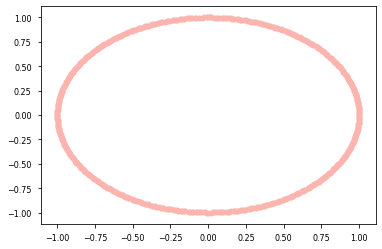

In [31]:
u = np.array(([0,1]))

us = [u]
for i in range(500):
    u = good_omega.dot(u)
    us.append(u)
    

us = np.asarray(us)
plt.scatter(us[:,0], us[:,1], c='#fbb4ae')

In [32]:
u0 = np.array(([0.0, 2]))
u1 = np.array(([0.0, 2.5]))
u2 = np.array(([0.0, 3]))

data_truth0 = solution_general_linear(Lambda=Lambda, u0=u0, ts=anal_ts)
data_est0 = solution_general_linear(Lambda=good_lambda, u0=u0, ts=anal_ts)

data_truth1 = solution_general_linear(Lambda=Lambda, u0=u1, ts=anal_ts)
data_est1 = solution_general_linear(Lambda=good_lambda, u0=u1, ts=anal_ts)
              
data_truth2 = solution_general_linear(Lambda=Lambda, u0=u2, ts=anal_ts)
data_est2 = solution_general_linear(Lambda=good_lambda, u0=u2, ts=anal_ts)              

(-3.5, 3.5)

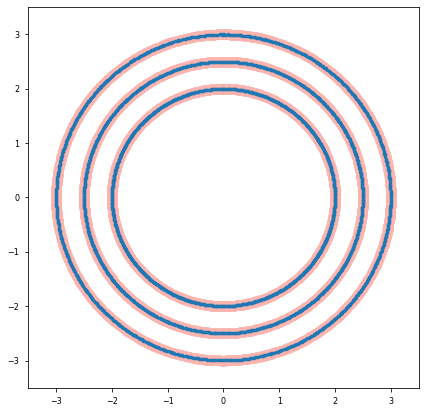

In [33]:
us = np.asarray(us)

plt.figure(figsize=(7,7))
plt.scatter(data_truth0[:,0], data_truth0[:,1], c='#fbb4ae', label='True solution', s=100)
plt.scatter(data_est0[:,0], data_est0[:,1], c='#1f78b4', label='Estimated solution', s=10)

plt.scatter(data_truth1[:,0], data_truth1[:,1], c='#fbb4ae', label='True solution', s=100)
plt.scatter(data_est1[:,0], data_est1[:,1], c='#1f78b4', label='Estimated solution', s=10)

plt.scatter(data_truth2[:,0], data_truth2[:,1], c='#fbb4ae', label='True solution', s=100)
plt.scatter(data_est2[:,0], data_est2[:,1], c='#1f78b4', label='Estimated solution', s=10)
plt.ylim(-3.5, 3.5)
plt.xlim(-3.5, 3.5)
#plt.legend(fontsize=22)


In [34]:
u0

array([0., 2.])

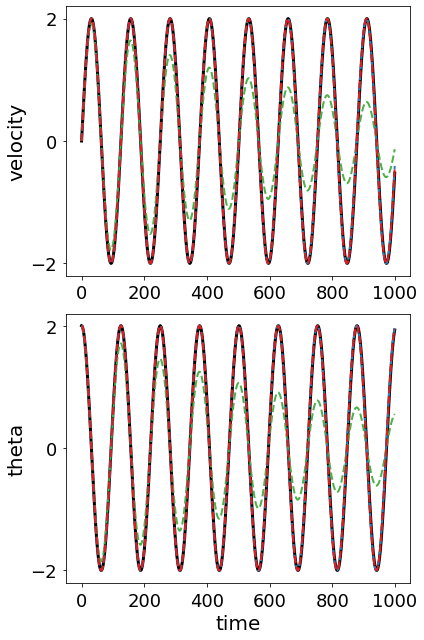

In [35]:
plt.figure(figsize=(6,9))

plt.subplot(2,1,1)


plt.plot(data_truth0[:,0], c='k', lw=3, label='truth')

good_lambda = results[('FW',)][2]
data_est0 = solution_general_linear(Lambda=good_lambda, u0=u0, ts=anal_ts)
plt.plot(data_est0[:,0], '--', c='#4daf4a', label='FW loss', lw=2)

good_lambda = results[('TR',)][2]
data_est0 = solution_general_linear(Lambda=good_lambda, u0=u0, ts=anal_ts)
plt.plot(data_est0[:,0], '--', c='#377eb8', label='TR loss', lw=2)


good_lambda = results[('FW', 'BW', 'TR')][2]
data_est0 = solution_general_linear(Lambda=good_lambda, u0=u0, ts=anal_ts)
plt.plot(data_est0[:,0], '--', c='#e41a1c', label='MIX loss', lw=2)



plt.tick_params(axis='y', labelsize=18)
plt.tick_params(axis='x', labelsize=18)      
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=6)
plt.ylabel('velocity', fontsize=20)
#plt.xlabel('time', fontsize=20)

plt.ylim(-2.2,2.2)

#plt.legend(fontsize=18)
plt.tight_layout()

plt.subplot(2,1,2)


plt.plot(data_truth0[:,1], c='k', lw=3, label='truth')

good_lambda = results[('FW',)][2]
data_est0 = solution_general_linear(Lambda=good_lambda, u0=u0, ts=anal_ts)
plt.plot(data_est0[:,1], '--', c='#4daf4a', label='FW loss', lw=2)

good_lambda = results[('TR',)][2]
data_est0 = solution_general_linear(Lambda=good_lambda, u0=u0, ts=anal_ts)
plt.plot(data_est0[:,1], '--', c='#377eb8', label='TR loss', lw=2)


good_lambda = results[('FW', 'BW', 'TR')][2]
data_est0 = solution_general_linear(Lambda=good_lambda, u0=u0, ts=anal_ts)
plt.plot(data_est0[:,1], '--', c='#e41a1c', label='MIX loss', lw=2)



plt.tick_params(axis='y', labelsize=18)
plt.tick_params(axis='x', labelsize=18)      
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=6)
plt.ylabel('theta', fontsize=20)
plt.xlabel('time', fontsize=20)
#plt.legend(fontsize=18)

plt.ylim(-2.2,2.2)

plt.tight_layout()

plt.savefig(case + '_ho_pred_lambda' + '.eps')


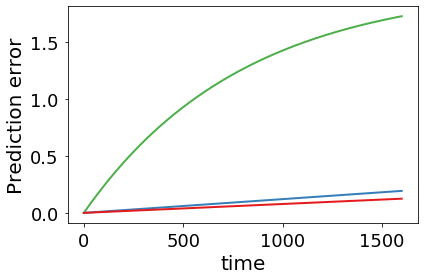

In [37]:
#plt.figure(figsize=(8,6))
u0 = np.array((0,2))
anal_ts_long = np.arange(0, 80, step=dt)
data_truth0 = solution_general_linear(Lambda=Lambda, u0=u0, ts=anal_ts_long)

good_lambda = results[('FW',)][2]
data_est0 = solution_general_linear(Lambda=good_lambda, u0=u0, ts=anal_ts_long)
errors = np.linalg.norm(data_truth0-data_est0, axis=1)
plt.plot(errors, '-', c='#4daf4a', label='FW loss', lw=2)

good_lambda = results[('TR',)][2]
data_est0 = solution_general_linear(Lambda=good_lambda, u0=u0, ts=anal_ts_long)
errors = np.linalg.norm(data_truth0-data_est0, axis=1)
plt.plot(errors, '-', c='#377eb8', label='TR loss', lw=2)


good_lambda = results[('FW', 'BW', 'TR')][2]
data_est0 = solution_general_linear(Lambda=good_lambda, u0=u0, ts=anal_ts_long)
errors = np.linalg.norm(data_truth0-data_est0, axis=1) 
plt.plot(errors, '-', c='#e41a1c', label='MIX loss', lw=2)


plt.tick_params(axis='y', labelsize=18)
plt.tick_params(axis='x', labelsize=18)      
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=6)
plt.ylabel('Prediction error', fontsize=20)
plt.xlabel('time', fontsize=20)
#plt.yscale("log")
plt.legend(fontsize=18)

plt.tight_layout()

plt.savefig(case + '_ho_pred_error_lambda' + '.eps')